In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])
plt.rcParams["figure.figsize"] = (8, 4)

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from SCFInitialGuess.utilities.usermessages import Messenger as msg
msg.print_level = 0

# Fetch Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#[S, P] = np.load()
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))


#ind = int(0.8 * len(index))
ind = 0

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])
#molecules = ([], molecules)

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test = S.reshape(-1, dim, dim)
#p_test = S.reshape(-1, dim, dim)

In [4]:
subfolder = "EmbeddedDensities/"

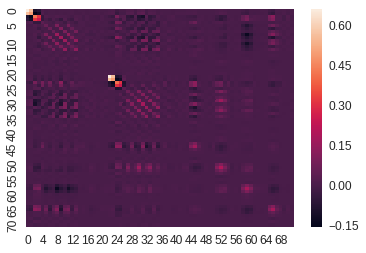

In [5]:
import seaborn as sns

sns.heatmap(P[0].reshape(dim, dim))

# Utilities 

In [6]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer_standard

def mf_initializer(mol):
    mf = mf_initializer_standard(mol)
    return mf

In [7]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    #train=(None, None),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

In [8]:
print(make_results_str(measure_all_quantities(
    p_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
0.00000E+00 +- 0.00000E+00
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.07827E-17 +- 6.96398E-18
--- Occupance Error ---
5.12144E-15 +- 4.27860E-15
--- HF Energy Error ---
9.32720E-15 +- 1.15198E-14
--- Avg. Iterations ---
1.00000E+00 +- 0.00000E+00
--- Avg. Iterations W/O Non Converged ---
1.00000E+00 +- 0.00000E+00
--- Num. Not Convd. ---
0



# Pure blocks

i will now set all other elements zero

## Utilities

In [9]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

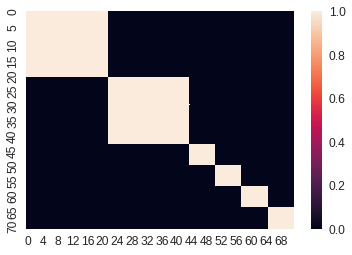

In [10]:
import seaborn as sns

sns.heatmap(mask.astype("int"))

In [11]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def extract_pure(p):
    p_batch = p.copy()
    p_batch[np.logical_not(mask)] = 0
    return p_batch

p_pure = np.array(list(map(extract_pure, p_test))).astype("float64")

In [12]:
np.save(data_path + subfolder + "p_pure.npy", p_pure)

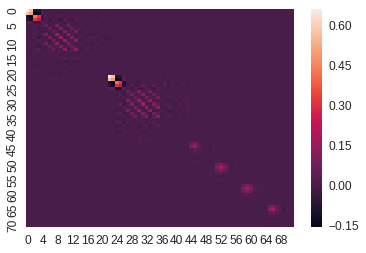

In [13]:
sns.heatmap(p_pure[0])

In [14]:
print(make_results_str(measure_all_quantities(
    p_pure,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
8.20873E-03 +- 6.77712E-03
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
8.46690E-03 +- 1.43952E-03
--- Occupance Error ---
3.07556E+00 +- 6.47749E-01
--- HF Energy Error ---
4.28340E+00 +- 1.13191E+00
--- Avg. Iterations ---
3.16064E+01 +- 1.77203E+01
--- Avg. Iterations W/O Non Converged ---
2.77827E+01 +- 7.44496E+00
--- Num. Not Convd. ---
53



# Embedding the Blocks In Classical Guesses

In [15]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd(p_guess, p_conv))
    return np.array(p_embedded)


## Convergedn in Converged 

In [16]:
p_test_test = embedd_batch(p_test)

In [17]:
print(make_results_str(measure_all_quantities(
    p_test_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
0.00000E+00 +- 0.00000E+00
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.07827E-17 +- 6.96398E-18
--- Occupance Error ---
5.12144E-15 +- 4.27860E-15
--- HF Energy Error ---
9.61114E-15 +- 1.14614E-14
--- Avg. Iterations ---
1.00000E+00 +- 0.00000E+00
--- Avg. Iterations W/O Non Converged ---
1.00000E+00 +- 0.00000E+00
--- Num. Not Convd. ---
0



## H_core

In [18]:
from pyscf.scf import hf

p_1e = np.array([ 
    hf.init_guess_by_1e(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [19]:
np.save(data_path + subfolder + "p_1e.npy", p_1e)

In [20]:
print(make_results_str(measure_all_quantities(
    p_1e,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
2.81846E-02 +- 3.21377E-02
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
5.75937E-17 +- 1.78283E-17
--- Occupance Error ---
5.86854E-15 +- 4.68053E-15
--- HF Energy Error ---
1.98890E+01 +- 1.35611E+00
--- Avg. Iterations ---
9.98761E+01 +- 2.76893E+00
--- Avg. Iterations W/O Non Converged ---
3.80000E+01 +- 1.00000E+00
--- Num. Not Convd. ---
999



## Embedd H_core

In [21]:
p_embedded_1e = embedd_batch(p_1e)

In [22]:
np.save(data_path + subfolder + "p_embedded_1e.npy", p_embedded_1e)

In [23]:
print(make_results_str(measure_all_quantities(
    p_embedded_1e,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.45666E-02 +- 1.41999E-02
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
3.29187E-02 +- 1.58313E-02
--- Occupance Error ---
4.50708E+00 +- 1.27343E+00
--- HF Energy Error ---
7.38029E+00 +- 4.18001E+00
--- Avg. Iterations ---
6.84675E+01 +- 3.47102E+01
--- Avg. Iterations W/O Non Converged ---
3.12331E+01 +- 8.18310E+00
--- Num. Not Convd. ---
542



In [24]:
117/201

0.582089552238806

## GWH

In [25]:
from pyscf.scf import hf

p_gwh = np.array([ 
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [26]:
np.save(data_path + subfolder + "p_gwh.npy", p_gwh)

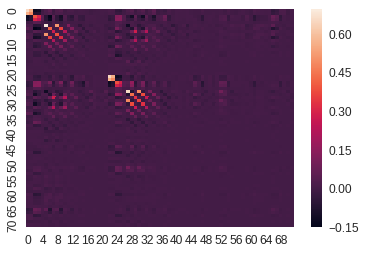

In [27]:
sns.heatmap(p_gwh[0])

In [28]:
print(make_results_str(measure_all_quantities(
    p_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.44548E-02 +- 1.09225E-02
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
2.84630E-17 +- 5.36726E-18
--- Occupance Error ---
4.89607E-15 +- 4.09765E-15
--- HF Energy Error ---
4.90516E+00 +- 4.94588E-01
--- Avg. Iterations ---
9.78162E+01 +- 1.18032E+01
--- Avg. Iterations W/O Non Converged ---
3.57059E+01 +- 1.04051E+01
--- Num. Not Convd. ---
967



In [29]:
190/201

0.945273631840796

## Embedded GWH 

In [30]:
p_embedded_gwh = embedd_batch(p_gwh)

In [31]:
np.save(data_path + subfolder + "p_embedded_gwh.npy", p_embedded_gwh)

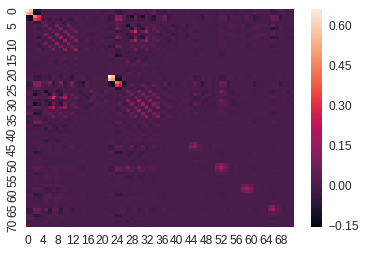

In [32]:
sns.heatmap(p_embedded_gwh[0])

In [33]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
9.32390E-03 +- 6.48266E-03
--- Symmetry Error ---
0.00000E+00 +- 0.00000E+00
--- Idempotence Error ---
1.27515E-02 +- 2.25357E-03
--- Occupance Error ---
1.45108E+00 +- 6.12645E-01
--- HF Energy Error ---
1.86918E+00 +- 8.92683E-01
--- Avg. Iterations ---
2.50799E+01 +- 6.64060E+00
--- Avg. Iterations W/O Non Converged ---
2.50799E+01 +- 6.64060E+00
--- Num. Not Convd. ---
0



## SAD 

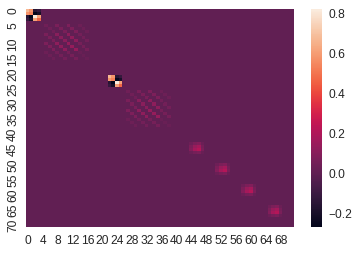

In [34]:
from pyscf.scf import hf

p_sad = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

sns.heatmap(p_sad[0])

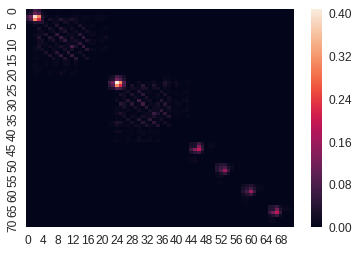

In [35]:
sns.heatmap(np.abs(p_sad[0]-p_pure[0]))

In [36]:
np.save(data_path + subfolder + "p_sad.npy", p_sad)

In [37]:
print(make_results_str(measure_all_quantities(
    p_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
1.18737E-02 +- 9.66758E-03
--- Symmetry Error ---
5.61871E-20 +- 1.28201E-20
--- Idempotence Error ---
1.16617E-02 +- 6.15850E-04
--- Occupance Error ---
3.50480E-15 +- 3.12819E-15
--- HF Energy Error ---
4.72071E-01 +- 2.54231E-01
--- Avg. Iterations ---
2.54116E+01 +- 8.09326E+00
--- Avg. Iterations W/O Non Converged ---
2.54116E+01 +- 8.09326E+00
--- Num. Not Convd. ---
0



## Embedded SAD

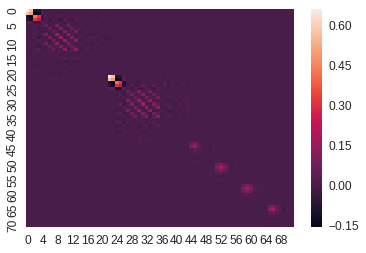

In [38]:
p_embedded_sad = embedd_batch(p_sad)
sns.heatmap(p_embedded_sad[0])

In [39]:
np.save(data_path + subfolder + "p_embedded_sad.npy", p_embedded_sad)

In [40]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

--- Absolute Error ---
8.20873E-03 +- 6.77712E-03
--- Symmetry Error ---
2.46748E-32 +- 1.57773E-32
--- Idempotence Error ---
8.46690E-03 +- 1.43952E-03
--- Occupance Error ---
3.07556E+00 +- 6.47749E-01
--- HF Energy Error ---
4.28340E+00 +- 1.13191E+00
--- Avg. Iterations ---
3.16064E+01 +- 1.77203E+01
--- Avg. Iterations W/O Non Converged ---
2.77827E+01 +- 7.44496E+00
--- Num. Not Convd. ---
53



In [41]:
11/201

0.05472636815920398

# McWheeny

In [42]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

def multi_mc_wheeny_batch(p_batch):
    p_res = []
    for p, s in zip(p_batch, s_test):
        p_res.append(multi_mc_wheeny(p, s, 5))
    return np.asarray(p_res)

## GWH 

In [43]:
p_embedded_gwh_mcw5 = multi_mc_wheeny_batch(p_embedded_gwh)

In [44]:
np.save(data_path + subfolder + "p_embedded_gwh_mcw5.npy", p_embedded_gwh_mcw5)

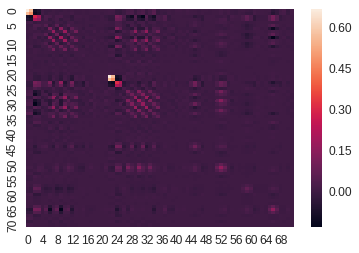

In [45]:
sns.heatmap(p_embedded_gwh_mcw5[0])

In [46]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

/home/jcartus/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


ValueError: array must not contain infs or NaNs

In [ ]:
49/201

## SAD 

In [ ]:
p_embedded_sad_mcw5 = multi_mc_wheeny_batch(p_embedded_sad)

In [ ]:
np.save(data_path + subfolder + "p_embedded_sad_mcw5.npy", p_embedded_sad_mcw5)

In [ ]:
sns.heatmap(p_embedded_gwh_mcw5[0])

In [ ]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

In [ ]:
114/201

# Embedd Outer 

In [ ]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_outer(x, y):
    p = x.copy()
    p[np.logical_not(mask)] = (y.copy())[np.logical_not(mask)]
    return p

def embedd_batch_outer(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_outer(p_guess, p_conv))
    return np.array(p_embedded)

## Converged 

In [ ]:
print(make_results_str(measure_all_quantities(
    embedd_batch_outer(p_test),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

In [ ]:
print(make_results_str(measure_all_quantities(
    embedd_batch_outer(p_embedded_sad),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

## SAD 

In [ ]:
p_embedded_outer_sad = embedd_batch_outer(p_sad)
sns.heatmap(p_embedded_outer_sad[0])

In [ ]:
np.save(data_path + subfolder + "p_embedded_outer_sad.npy", p_embedded_outer_sad)

In [ ]:
print(make_results_str(measure_all_quantities(
    p_embedded_outer_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

In [ ]:
68 / 201

## GWH 

In [ ]:
p_embedded_outer_gwh = embedd_batch_outer(p_gwh)
sns.heatmap(p_embedded_outer_gwh[0])

In [ ]:
np.save(data_path + subfolder + "p_embedded_outer_gwh.npy", p_embedded_outer_gwh)

In [ ]:
print(make_results_str(measure_all_quantities(
    p_embedded_outer_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

In [ ]:
194 / 201